# Mathematics of Deep Learning

## Packages from previous 

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Basic ML Workflow
1. For each model, fit it to the *training set*
2. Compute the error for each model on the *validation set*
3. Select the model with the lowest validation error
4. Compute the error of the final model on the *test set*

### Questions to answer in ML project
1. **(SELECTION)** Which of these models is the best?
2. **(Future Performance)** How good should we expect the final model to be on unseen data?

## Diviser en trois - split 3 ways

In [18]:
# import the data
from sklearn.datasets import fetch_california_housing
features, target = fetch_california_housing(as_frame=True, return_X_y=True)

# split data into train, validation and test sets
X_main, X_test, y_main, y_test = \
    train_test_split(features, target, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = \
    train_test_split(X_main, y_main, test_size=0.25, random_state=1) # As 0.25 x 0.8 = 0.2

## Model Building Flow as Code

In [19]:
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_val_sc = sc.transform(X_val)
X_test_sc = sc.transform(X_test)

# For each model, fit it to the training set
tf.random.set_seed(1234)
model = Sequential([
    Dense(30, activation="relu"),
    Dense(1, activation="exponential")
])
model.compile("adam", "mse")
%time hist = model.fit(X_train_sc, y_train, epochs=100, verbose=False)

# Compute the error for each model on the validation set and select model with lowest error
mseExpAnnTrain = mean_squared_error(y_train, model.predict(X_train_sc))
mseExpAnnVal = mean_squared_error(y_val, model.predict(X_val_sc))

mseTrain = {"Exp ANN": mseExpAnnTrain}
mseVal = {"Exp ANN": mseExpAnnVal}

# Evaluate only the final model on the test set
mean_squared_error(y_test, model.predict(X_test_sc))
model.evaluate(X_test_sc, y_test, verbose=False)

CPU times: total: 34 s
Wall time: 29.4 s
129/129 [==============================] - 0s 787us/step


0.32625776529312134

## Early Stopping

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(1234)
model = Sequential([
    Dense(30, activation="relu"),
    Dense(1, activation="exponential")
])
model.compile("adam", "mse")

es = EarlyStopping(restore_best_weights=True, patience=10)

%time hist = model.fit(X_train_sc, y_train, epochs=1_000, \
    callbacks=[es], validation_data=(X_val_sc, y_val), verbose=False)
print(f"Keeping model at epoch #{len(hist.history['loss'])-10}.")

CPU times: total: 27.7 s
Wall time: 23.5 s
Keeping model at epoch #48.


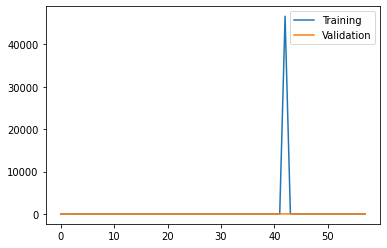

In [21]:
# Loss curve
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.legend(["Training", "Validation"]);

In [22]:
# Other callbacks
from tensorflow.keras.callbacks import ModelCheckpoint

tf.random.set_seed(1234)
model = Sequential([
    Dense(30, activation="relu"),
    Dense(1, activation="exponential")
])
model.compile("adam", "mse")

# On Colab, save models to Google Drive.
mc = ModelCheckpoint("best-model.h5", monitor="val_loss",
        save_best_only=True)
es = EarlyStopping(restore_best_weights=True, patience=5)

hist = model.fit(X_train_sc, y_train, epochs=100, \
    validation_split=0.1, callbacks=[mc, es], verbose=False)

'file' is not recognized as an internal or external command,
operable program or batch file.


## Classification 

### Softmax activation for final layer
- Creates a probability vector: Softmax(x) = $\frac{e_i^x}{\Sigma_j e^x_j}$

### Data Set Up

In [23]:
# Import data
from sklearn.datasets import load_iris
iris = load_iris()
names = ["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"]
features = pd.DataFrame(iris.data, columns = names)

In [24]:
# Target variable
target = iris.target
target = target.reshape(-1, 1)

In [25]:
# Frequency table
classes, counts = np.unique(
        target,
        return_counts=True
)
print(classes)
print(counts)

[0 1 2]
[50 50 50]


### Modelling

In [30]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=24)

In [60]:
# Number of features and categories
NUM_FEATURES = len(features.columns)
NUM_CATS = len(np.unique(target))

print("Number of features:", NUM_FEATURES)
print("Number of categories:", NUM_CATS)

Number of features: 4
Number of categories: 3


In [32]:
# Function to return a Keras model
def build_model(seed=42):
    tf.random.set_seed(seed)
    return Sequential([
        Dense(30, activation="relu"),
        Dense(NUM_CATS, activation="softmax") # softmax for classification
    ])

In [36]:
model = build_model()
model.compile("adam", "SparseCategoricalCrossentropy", \
        metrics=["accuracy"])

es = EarlyStopping(restore_best_weights=True, patience=50,
        monitor="val_accuracy")
%time histES = model.fit(X_train, y_train, epochs=500, \
        validation_split=0.25, callbacks=[es], verbose=False);

print(f"Stopped after {len(histES.history['loss'])} epochs.")



CPU times: total: 4.08 s
Wall time: 3.45 s
Stopped after 170 epochs.


In [37]:
# Evaluate model - note it shows both loss and accuracy
model.evaluate(X_test, y_test, verbose=False)

[0.34775248169898987, 0.9736841917037964]

### Predictions

In [38]:
y_pred = model.predict(X_test.head(4))
y_pred

1/1 [==============================] - 0s 34ms/step


array([[0.00407997, 0.2903609 , 0.70555913],
       [0.00736918, 0.33165058, 0.66098017],
       [0.12062447, 0.6610642 , 0.21831135],
       [0.05547402, 0.63195974, 0.3125663 ]], dtype=float32)

In [39]:
# Add 'keepdims=True' to get a column vector.
np.argmax(y_pred, axis=1)

array([2, 2, 1, 1], dtype=int64)

In [40]:
# show predictions as their class names
iris.target_names[np.argmax(y_pred, axis=1)]

array(['virginica', 'virginica', 'versicolor', 'versicolor'], dtype='<U10')

### One Hot Encoding

In [42]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

y_train_oh = enc.fit_transform(y_train)
y_test_oh = enc.transform(y_test)

In [45]:
# Classifier given one-hot outputs

# Create the model (new loss function!)
model = build_model()
model.compile("adam", "CategoricalCrossentropy", \
    metrics=["accuracy"])

# Fit the model (new target variables)
model.fit(X_train, y_train_oh, epochs=100, verbose=False);

# Evaluate the model (new target variables)
model.evaluate(X_test, y_test_oh, verbose=False)

[0.29562538862228394, 0.9736841917037964]

In [58]:
# Categorical boolean mask
categorical_features_mask = (features.dtypes==object)

#filter categorical columns using mask and turn into a list
categorical_cols = features.columns[categorical_features_mask].tolist()
categorical_cols

[]

## Poisson Regression, Deviance and Loss

### The model
Have $[(xi,yi)]_{i=1,…,n}$ for $ x_i∈R^{47} $ and $ y_i∈N_0 $.

Assume the distribution

$Y_i∼Poisson(λ(x_i))$

We have $\mathbb{E}Y_i=λ(x_i)$. The NN takes $x_i$ and predicts $\mathbb{E}Y_i$.


### Poisson Probabilities 
Since the PMF of the N∼Poisson(λ) distribution is $\mathbb{P}(N=k)=\frac {λ^ke{−λ}} / {k!}$ then the PMF of $Y_i∼Poisson(λ(x_i))$ is
$$\mathbb{P}(Y_i=y_i)=\frac{λ(x_i)^{y_i}e{−λ(xi)}} {y_i!}$$

The likelihood of a sample is then:
$$\mathbb{P}(Y_1=y_1,…,Y_n=y_n)=\prod_{i=1}^n \mathbb{P}(Y_i=y_i)$$

Therefore, the likelihod of $[(x_i,y_i)]_{i=1,…,n}$ is:
$$L= \prod_{i=1}^n \frac{λ(x_i)^{y_i}e{−λ(xi)}} {y_i!}$$

So the log-likelihood is:
$$l = \sum_{i=1}^n y_i log(\lambda(x_i)) - \lambda(x_i) - log(y_i!)$$

We want to maximise the likelihood:
$$\lambda^* = ... = arg min_\lambda \frac {1} {n} \sum_{i=1}^n \lambda (x_i) - y_i log(\lambda(x_i))$$

Hence, Poisson Loss is:
$$PoissonLoss = \frac {1} {n} \sum_{i=1}^n \lambda (x_i) - y_i log(\lambda(x_i))




### Poisson Deviance
$$ D = 2 \sum_{i=1}^n y_i log(\frac{y_i}{\lambda(x_i)}) - (y_i-\lambda(x_i))

## Optimisation

### Batch gradient descent
Go over all the training data

    for i in range(numEpochs):
      gradient = evaluate_gradient(loss_function, data, weights)
      weights = weights - learningRate * gradient


### Stochastic gradient descent
Pick a random training example

    for i in range(numEpochs):
      rnd.shuffle(data)
      for example in data:
        gradient = evaluate_gradient(loss_function, example, weights)
        weights = weights - learningRate * gradient


### Mini-batch gradient descent
Take a group of training examples

    for i in range(numEpochs):
      rnd.shuffle(data)
      for b in range(numBatches):
        batch = data[b*batchSize:(b+1)*batchSize]
        gradient = evaluate_gradient(loss_function, batch, weights)
        weights = weights - learningRate * gradient

Why?
- We have to - data is too big
- Faster - lots of quick noisy steps > a few slow super accurate steps
- Noise helps us jump out of local minima

## Classes and Objects
Often, the built-in types (int, double, list, etc.) aren’t enough. Need to make a new type of object.

Example - students with name, zID, grades + shared way to calculate WAM

In [49]:
class Student:
    def __init__(self, name, zID, grades): 
        self.name = name
        self.zID = zID
        self.grades = grades

# The first parameter for each function inside a class is self.

In [50]:
#Adding a method
COURSE_CREDITS = {"ACTL3143": 6, "ACTL5001": 12}

class Student:
  def __init__(self, name, zID, grades):
    self.name = name
    self.zID = zID
    self.grades = grades

  def wam(self):
    """
    Calculate the weighted average mark for this student.
    """
    total_credits = 0
    total_grade = 0
    for course, grade in self.grades.items():
      total_credits += COURSE_CREDITS[course]
      total_grade += grade * COURSE_CREDITS[course]
    return total_grade / total_credits

In [51]:
don = Student("Don Quixote", 111222,
    {"ACTL3143": 100, "ACTL5001": 50})
zhuge = Student("Zhuge Liang", 123456,
    {"ACTL3143": 100, "ACTL5001": 100})

In [52]:
don.wam()
#syntax is object.method()

66.66666666666667

In [53]:
help(zhuge.wam)

Help on method wam in module __main__:

wam() method of __main__.Student instance
    Calculate the weighted average mark for this student.



## Lambda Functions

In [55]:
# sort students by length of name 
names = ["Josephine", "Patrick", "Bert"]
sorted(names, key=len)

['Bert', 'Patrick', 'Josephine']

In [56]:
#sort students by second letter using new function
def secondLetter(name):
    return name[1]

sorted(names, key=secondLetter)

['Patrick', 'Bert', 'Josephine']

In [57]:
# sort students by second letter using a lambda function
sorted(names, key=lambda name: name[1])

['Patrick', 'Bert', 'Josephine']